## Dependencies

All the dependencies for this notebook are included in the `requirements.txt` file included in this folder.


In [3]:
from radiant_mlhub import Collection
import tarfile
import os
from pathlib import Path
import json

import geopandas as gpd
import datetime
import rasterio
import numpy as np
import pandas as pd
import elevation
import shapely

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from rasterio.plot import show

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit

from IPython.display import clear_output

In [4]:
fields_train_mean_var_s2 = pd.read_csv('data/mean_var_s2_16days_train.csv')
fields_train_mean_var_s1 = pd.read_csv('data/mean_var_s1_16days_train.csv')

df_columns = fields_train_mean_var_s1.columns
fields_train_mean_var = fields_train_mean_var_s2.merge(fields_train_mean_var_s1.drop(df_columns[1:16], axis = 1), on ="field_id")
fields_train_mean_var.head()

,field_id,label,tile_id,field_area_km2,elevation,geometry,neighboor_label_1,neighboor_label_2,neighboor_label_3,neighboor_label_4,...,VV_VAR_13,VH_VAR_13,VV_MEAN_14,VH_MEAN_14,VV_VAR_14,VH_VAR_14,VV_MEAN_15,VH_MEAN_15,VV_VAR_15,VH_VAR_15
0,3020,2,2587,0.001702,197.333333,"POLYGON ((18.572953 -33.570726, 18.572933 -33....",0.153001,0.429634,0.016667,0.024266,...,6.103806,62.692042,2.764706,10.882353,3.121107,19.280277,2.250000,14.764706,1.687500,18.885813
1,99466,2,2587,0.042403,173.574074,"POLYGON ((18.575171 -33.572303, 18.575128 -33....",0.153001,0.429634,0.016667,0.024266,...,7.558983,72.377308,2.111392,9.172170,1.197718,21.930263,2.009091,9.617925,1.560523,22.504962
2,15902,5,2587,0.029503,149.222222,"POLYGON ((18.580872 -33.572594, 18.580869 -33....",0.153001,0.429634,0.016667,0.024266,...,20.844511,125.589267,2.382456,10.877966,2.137938,39.435955,2.238462,12.945763,1.681598,56.478414
3,38846,3,2587,0.069601,89.761364,"POLYGON ((18.598422 -33.572846, 18.598419 -33....",0.153001,0.429634,0.016667,0.024266,...,3.133297,98.075263,2.254386,8.545586,2.554586,38.847054,2.537919,10.568966,2.996358,56.825704
4,87981,1,2587,0.022603,90.272727,"POLYGON ((18.591885 -33.587145, 18.591862 -33....",0.153001,0.429634,0.016667,0.024266,...,4.363554,28.903032,2.291262,8.716814,2.196720,37.893257,2.583756,10.938053,6.019635,50.403242


In [5]:
"""
Cheap NN
"""

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, log_loss

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout, Input, Concatenate, Bidirectional, GRU
from tensorflow.keras.utils import to_categorical, plot_model

#from keras.utils import to_categorical
#from keras.models import Sequential # intitialize the ANN
#from keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional, RNN   # create layers

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
BS_cols = []
for col in fields_train_mean_var.columns:
    if "BS" in col:
        BS_cols.append(col)
BS_cols

In [ ]:
X_train.iloc[:,9:]

In [6]:
X = fields_train_mean_var.drop(['field_id', 'label', 'geometry', 'tile_id'], axis=1)
y = fields_train_mean_var.label

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=fields_train_mean_var.label)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

print(y_train_onehot.shape)
print(y_test_onehot.shape)

(87113, 556)
(60979, 10)
(26134, 10)


In [9]:
X.shape

(87113, 556)

In [10]:
# Initialising the NN
model = Sequential()

# layers
#model.add(Dense(units = 1024, kernel_initializer = 'HeUniform', activation = 'relu', input_dim = 521))
#model.add(Dropout(0.3))
model.add(Dense(units = 1024, kernel_initializer = 'HeUniform', activation = 'relu', input_dim = 556))
model.add(Dropout(0.3))
model.add(Dense(units = 256, kernel_initializer = 'HeUniform', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 128, kernel_initializer = 'HeUniform', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64, kernel_initializer = 'HeUniform', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 16, kernel_initializer = 'HeUniform', activation = 'relu'))
model.add(Dense(units = 10, kernel_initializer = 'HeUniform',activation = 'softmax'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              570368    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

In [12]:
training = model.fit(X_train, y_train_onehot, batch_size = 500, validation_split=0.2, epochs = 20, verbose=2)

Epoch 1/20
98/98 - 8s - loss: 0.8683 - accuracy: 0.7012 - val_loss: 0.9532 - val_accuracy: 0.6763
Epoch 2/20
98/98 - 8s - loss: 0.8557 - accuracy: 0.7050 - val_loss: 0.9521 - val_accuracy: 0.6748
Epoch 3/20
98/98 - 7s - loss: 0.8492 - accuracy: 0.7091 - val_loss: 0.9569 - val_accuracy: 0.6757
Epoch 4/20
98/98 - 7s - loss: 0.8362 - accuracy: 0.7104 - val_loss: 0.9477 - val_accuracy: 0.6787
Epoch 5/20
98/98 - 7s - loss: 0.8218 - accuracy: 0.7181 - val_loss: 0.9532 - val_accuracy: 0.6811
Epoch 6/20
98/98 - 8s - loss: 0.8182 - accuracy: 0.7188 - val_loss: 0.9487 - val_accuracy: 0.6839
Epoch 7/20
98/98 - 8s - loss: 0.8044 - accuracy: 0.7218 - val_loss: 0.9526 - val_accuracy: 0.6847
Epoch 8/20
98/98 - 7s - loss: 0.7961 - accuracy: 0.7253 - val_loss: 0.9385 - val_accuracy: 0.6860
Epoch 9/20
98/98 - 7s - loss: 0.7864 - accuracy: 0.7292 - val_loss: 0.9298 - val_accuracy: 0.6860
Epoch 10/20
98/98 - 7s - loss: 0.7735 - accuracy: 0.7345 - val_loss: 0.9435 - val_accuracy: 0.6856
Epoch 11/20
98/98 -

In [13]:
y_test_pred_proba = model.predict(X_test)

In [14]:
y_test_pred = y_test_pred_proba.argmax(axis=-1)

In [15]:
print("Cross-Entropy-Loss:  " + str(log_loss(y_test_onehot, y_test_pred_proba, labels=y_test_onehot)))

Cross-Entropy-Loss:  0.9118466888909367


In [16]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.63      0.51      0.57      2502
           2       0.58      0.71      0.64      4175
           3       0.57      0.54      0.56      2374
           4       0.90      0.94      0.92      7268
           5       0.57      0.49      0.53      2441
           6       0.55      0.39      0.46      2475
           7       0.76      0.82      0.79      3214
           8       0.67      0.56      0.61       448
           9       0.63      0.76      0.69      1237

    accuracy                           0.70     26134
   macro avg       0.65      0.64      0.64     26134
weighted avg       0.69      0.70      0.69     26134



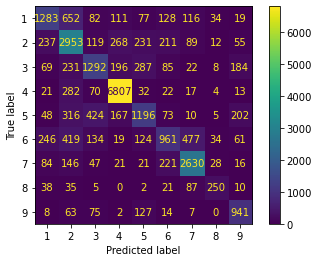

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred, labels=[1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6,7,8,9])
disp.plot()

In [45]:
y_pred_proba = model.predict(X_train)
y_pred = y_pred_proba.argmax(axis=-1)

In [ ]:
pd.DataFrame(y_pred_proba.round(2))

## Stepwise Model

In [41]:
df_clean = fields_train_mean_var.drop(['field_id', 'label', 'geometry', 'tile_id', 'elevation','field_area_km2','sun_rate'], axis=1)

df_clean.shape

(87113, 489)

9 first columns are the neighbor probabilies, the 240 the bands information. 30 per day.

In [42]:
X = fields_train_mean_var.drop(['field_id', 'label', 'geometry', 'tile_id', 'elevation','sun_rate','field_area_km2'], axis=1)
y = fields_train_mean_var.label

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=fields_train_mean_var.label)

scaler = StandardScaler()
X_train = np.concatenate((np.array(X_train.iloc[:,0:9]) , scaler.fit_transform(X_train.iloc[:,9:])),axis = 1)
X_test = np.concatenate((np.array(X_test.iloc[:,0:9]) , scaler.transform(X_test.iloc[:,9:])),axis = 1)


y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

print(y_train_onehot.shape)
print(y_test_onehot.shape)

(87113, 489)
(60979, 10)
(26134, 10)


In [54]:
num_days = 16

X_train_neighbors = X_train[:,0:9]

X_train_days = np.zeros(( 60979,num_days, 30))

for i in range (num_days):
    
    X_train_days[:,i,:] = np.concatenate((X_train[:, 9 + i*15 : 24 + i*15], X_train[:, 249 + i*15 : 264 + i*15]), axis = 1)

In [55]:
X_train_days.shape

(60979, 16, 30)

In [35]:
# define two sets of inputs
inputA = Input(shape=(9,))

inputs = []
combined = []
x = [] 
model_input = [inputA]

for i in range(num_days):
    
    inputs.append(Input(shape=(30,)))


# combine the output of the two branches
combined.append(tf.keras.layers.Concatenate(axis=1)([inputA, inputs[0]]))

print(len(combined))
# the first branch operates on the first input

for i in range(num_days):
    print(i)
    x.append(Dense(64, activation="relu")(combined[i]))
    #x[i] = Dropout(0.1)(x[i])
    x.append(Dense(32, activation="relu")(x[i]))
    x.append(Dense(10, activation="softmax")(x[i]))
    
    model_input.append(inputs[i])
    
# combine the output of the two branches
    if i < num_days - 1:
        combined.append(tf.keras.layers.Concatenate(axis=1)([x[i], inputs[i+1]]))
        
    

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs = model_input, outputs = x[num_days])
model.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
print(model.summary())
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_199 (InputLayer)          [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_200 (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
concatenate_30 (Concatenate)    (None, 39)           0           input_199[0][0]                  
                                                                 input_200[0][0]                  
__________________________________________________________________________________________________
dense_86 (Dense)                (None, 64)          

In [37]:
model_input = [X_train_neighbors]

for day in X_train_days:
    model_input.append(day)

training = model.fit(model_input, y_train_onehot, batch_size = 500, validation_split=0.2, epochs = 100, verbose=2)

Epoch 1/100


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:797 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1644 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 10) and (None, 32) are incompatible


In [62]:
model = keras.Sequential()
model.add(tf.keras.layers.Dense(input_dim=(16, 30), output_dim=(16, 30)))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)

model.add(tf.keras.layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(tf.keras.layers.SimpleRNN(128))

model.add(tf.keras.layers.Dense(10))

model.summary()

TypeError: __init__() missing 1 required positional argument: 'units'

In [48]:
model = keras.Sequential()


model.add(tf.keras.layers.GRU(10, return_sequences=True, return_state=True, input_shape=(60979, 30)))
#model.add(Dense(32, activation="relu"))
#model.add(Dense(10, activation="softmax"))

model.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

model.summary()

ValueError: All layers in a Sequential model should have a single output tensor. For multi-output layers, use the functional API.

In [ ]:
training = model.fit(X_train_days, y_train_onehot, batch_size = 500, validation_split=0.2, epochs = 5, verbose=2)

In [78]:
num_days = 8

X_test_neighbors = X_test[:,0:9]

X_test_days = []

for i in range (num_days):
    
    X_test_days[i,:,:] = np.concatenate((X_test[:, 9 + i*15 : 24 + i*15], X_test[:, 249 + i*15 : 264 + i*15]), axis = 1)


In [79]:
model_input_test = [X_test_neighbors]

for day in X_test_days:
    model_input_test.append(day)

y_test_pred_proba = model.predict(model_input_test)

In [80]:
y_test_pred = y_test_pred_proba.argmax(axis=-1)

In [81]:
print("Cross-Entropy-Loss:  " + str(log_loss(y_test_onehot, y_test_pred_proba, labels=y_test_onehot)))

Cross-Entropy-Loss:  1.0357482548662915


In [82]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.52      0.48      0.50      2502
           2       0.57      0.59      0.58      4175
           3       0.49      0.53      0.51      2374
           4       0.88      0.90      0.89      7268
           5       0.51      0.41      0.46      2441
           6       0.40      0.40      0.40      2475
           7       0.73      0.76      0.74      3214
           8       0.59      0.34      0.43       448
           9       0.58      0.66      0.61      1237

    accuracy                           0.65     26134
   macro avg       0.58      0.56      0.57     26134
weighted avg       0.64      0.65      0.64     26134



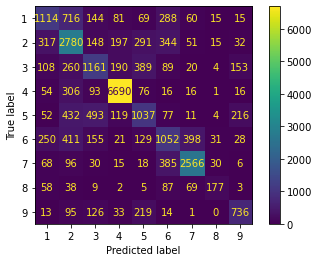

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred, labels=[1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6,7,8,9])
disp.plot()

In [73]:
#y_pred_proba = model.predict(X_train)
y_test_pred = y_pred_proba.argmax(axis=-1)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:203 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_16 expects 9 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 489) dtype=float32>]


In [75]:
pd.DataFrame(y_test_pred_proba.round(2))

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.03,0.05,0.13,0.51,0.27,0.00,0.00,0.00,0.01
1,0.0,0.07,0.75,0.04,0.01,0.08,0.04,0.01,0.00,0.00
2,0.0,0.22,0.63,0.00,0.00,0.02,0.10,0.02,0.00,0.00
3,0.0,0.10,0.04,0.01,0.01,0.00,0.40,0.28,0.16,0.00
4,0.0,0.00,0.00,0.01,0.98,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
26129,0.0,0.00,0.13,0.37,0.00,0.44,0.03,0.01,0.00,0.02
26130,0.0,0.01,0.00,0.00,0.00,0.00,0.08,0.90,0.01,0.00
26131,0.0,0.16,0.66,0.03,0.01,0.09,0.03,0.01,0.00,0.01
26132,0.0,0.04,0.68,0.05,0.00,0.02,0.19,0.01,0.00,0.00


## TEST DF

In [32]:
fields_test_mean_var_s2.columns

Index(['field_id', 'tile_id', 'field_area_km2', 'elevation', 'geometry',
       'neighboor_label_1', 'neighboor_label_2', 'neighboor_label_3',
       'neighboor_label_4', 'neighboor_label_5',
       ...
       'B06_VAR_15', 'B07_VAR_15', 'B08_VAR_15', 'B09_VAR_15', 'B11_VAR_15',
       'B12_VAR_15', 'B8A_VAR_15', 'BS_IDX_VAR_15', 'MOIST_IDX_VAR_15',
       'NDVI_IDX_VAR_15'],
      dtype='object', length=495)

In [18]:
fields_test_mean_var_s2 = pd.read_csv('data/mean_var_s2_16days_test.csv')
fields_test_mean_var_s1 = pd.read_csv('data/mean_var_s1_16days_test.csv')

df_columns = fields_test_mean_var_s1.columns


In [19]:
df_columns[1:16]

Index(['tile_id', 'field_area_km2', 'elevation', 'geometry',
       'neighboor_label_1', 'neighboor_label_2', 'neighboor_label_3',
       'neighboor_label_4', 'neighboor_label_5', 'neighboor_label_6',
       'neighboor_label_7', 'neighboor_label_8', 'neighboor_label_9',
       'sun_rate', 'VV_MEAN_0'],
      dtype='object')

In [21]:
fields_test_mean_var = fields_test_mean_var_s2.merge(fields_test_mean_var_s1.drop(df_columns[1:15], axis = 1), on ="field_id")
fields_test_mean_var.head()

,field_id,tile_id,field_area_km2,elevation,geometry,neighboor_label_1,neighboor_label_2,neighboor_label_3,neighboor_label_4,neighboor_label_5,...,VV_VAR_13,VH_VAR_13,VV_MEAN_14,VH_MEAN_14,VV_VAR_14,VH_VAR_14,VV_MEAN_15,VH_MEAN_15,VV_VAR_15,VH_VAR_15
0,62027,590,0.037301,33.562500,"POLYGON ((18.139509 -33.006831, 18.139504 -33....",0.076107,0.545629,0.0,0.0,0.066877,...,2.148058,27.541490,1.777778,5.455764,1.711301,12.500054,1.949612,7.583333,1.993585,25.748432
1,62071,590,0.050804,35.000000,"POLYGON ((18.146246 -33.006985, 18.146237 -33....",0.076107,0.545629,0.0,0.0,0.066877,...,3.399289,20.307601,1.648725,6.737673,2.222215,20.118561,1.975676,7.691700,1.975084,24.316018
2,85373,590,0.022991,34.464286,"POLYGON ((18.140448 -33.007574, 18.140445 -33....",0.076107,0.545629,0.0,0.0,0.066877,...,3.461728,22.525085,2.338095,8.934783,2.899977,22.330529,2.620513,14.121739,5.209836,54.767788
3,102896,590,0.281303,32.382184,"POLYGON ((18.130528 -33.006625, 18.130519 -33....",0.076107,0.545629,0.0,0.0,0.066877,...,2.427315,49.985066,1.421627,7.807255,0.781556,19.622166,1.904739,12.249377,1.502300,44.764207
4,3079,590,0.139693,34.314607,"POLYGON ((18.146543 -33.007713, 18.14654 -33.0...",0.076107,0.545629,0.0,0.0,0.066877,...,5.234146,51.136011,2.311956,9.200717,3.566975,35.932473,2.467323,9.709978,4.843382,38.248982


In [22]:
fields_test_mean_var.shape

(35295, 559)

In [23]:
X_VAL = fields_test_mean_var.drop(['field_id', 'geometry', 'tile_id'], axis=1)

In [24]:
X_VAL.shape

(35295, 556)

In [25]:
X_VAL = scaler.transform(X_VAL)

In [26]:
X_VAL_predict_proba = model.predict(X_VAL)

In [27]:
df_sol_proba = pd.DataFrame(X_VAL_predict_proba.round(2))

In [28]:
df_sol =  pd.concat([fields_test_mean_var['field_id'],df_sol_proba], axis =1)

In [29]:
df_sol

,field_id,0,1,2,3,4,5,6,7,8,9
0,62027,0.0,0.05,0.05,0.02,0.01,0.00,0.31,0.52,0.04,0.00
1,62071,0.0,0.20,0.51,0.02,0.01,0.03,0.18,0.04,0.01,0.00
2,85373,0.0,0.07,0.08,0.02,0.01,0.01,0.30,0.47,0.04,0.01
3,102896,0.0,0.05,0.09,0.01,0.01,0.01,0.40,0.41,0.02,0.00
4,3079,0.0,0.03,0.93,0.01,0.01,0.01,0.01,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
35290,117413,0.0,0.10,0.85,0.00,0.01,0.00,0.02,0.01,0.00,0.00
35291,16515,0.0,0.13,0.22,0.06,0.02,0.04,0.32,0.17,0.03,0.01
35292,59992,0.0,0.13,0.83,0.00,0.01,0.00,0.02,0.01,0.00,0.00
35293,61236,0.0,0.04,0.18,0.16,0.04,0.53,0.03,0.00,0.00,0.01


In [30]:
df_sol = df_sol[["field_id", 8, 3, 1,2,9,6,5,7,4]]
column_names = {"field_id": "Field ID",8:"Crop_Canola",3:"Crop_Fallow",1:"Crop_Lucerne/Medics",2:"Crop_Planted pastures (perennial)",9:"Crop_Rooibos",6:"Crop_Small grain grazing",5:"Crop_Weeds",7:"Crop_Wheat",4:"Crop_Wine grapes"}

df_sol_clean = df_sol.rename(columns = column_names)
df_sol_clean.head()

,Field ID,Crop_Canola,Crop_Fallow,Crop_Lucerne/Medics,Crop_Planted pastures (perennial),Crop_Rooibos,Crop_Small grain grazing,Crop_Weeds,Crop_Wheat,Crop_Wine grapes
0,62027,0.04,0.02,0.05,0.05,0.00,0.31,0.00,0.52,0.01
1,62071,0.01,0.02,0.20,0.51,0.00,0.18,0.03,0.04,0.01
2,85373,0.04,0.02,0.07,0.08,0.01,0.30,0.01,0.47,0.01
3,102896,0.02,0.01,0.05,0.09,0.00,0.40,0.01,0.41,0.01
4,3079,0.00,0.01,0.03,0.93,0.00,0.01,0.01,0.00,0.01


In [32]:
df_sol_clean.to_csv("Submission_4.csv", index=False)

## TSNE

In [63]:
from sklearn.manifold import TSNE

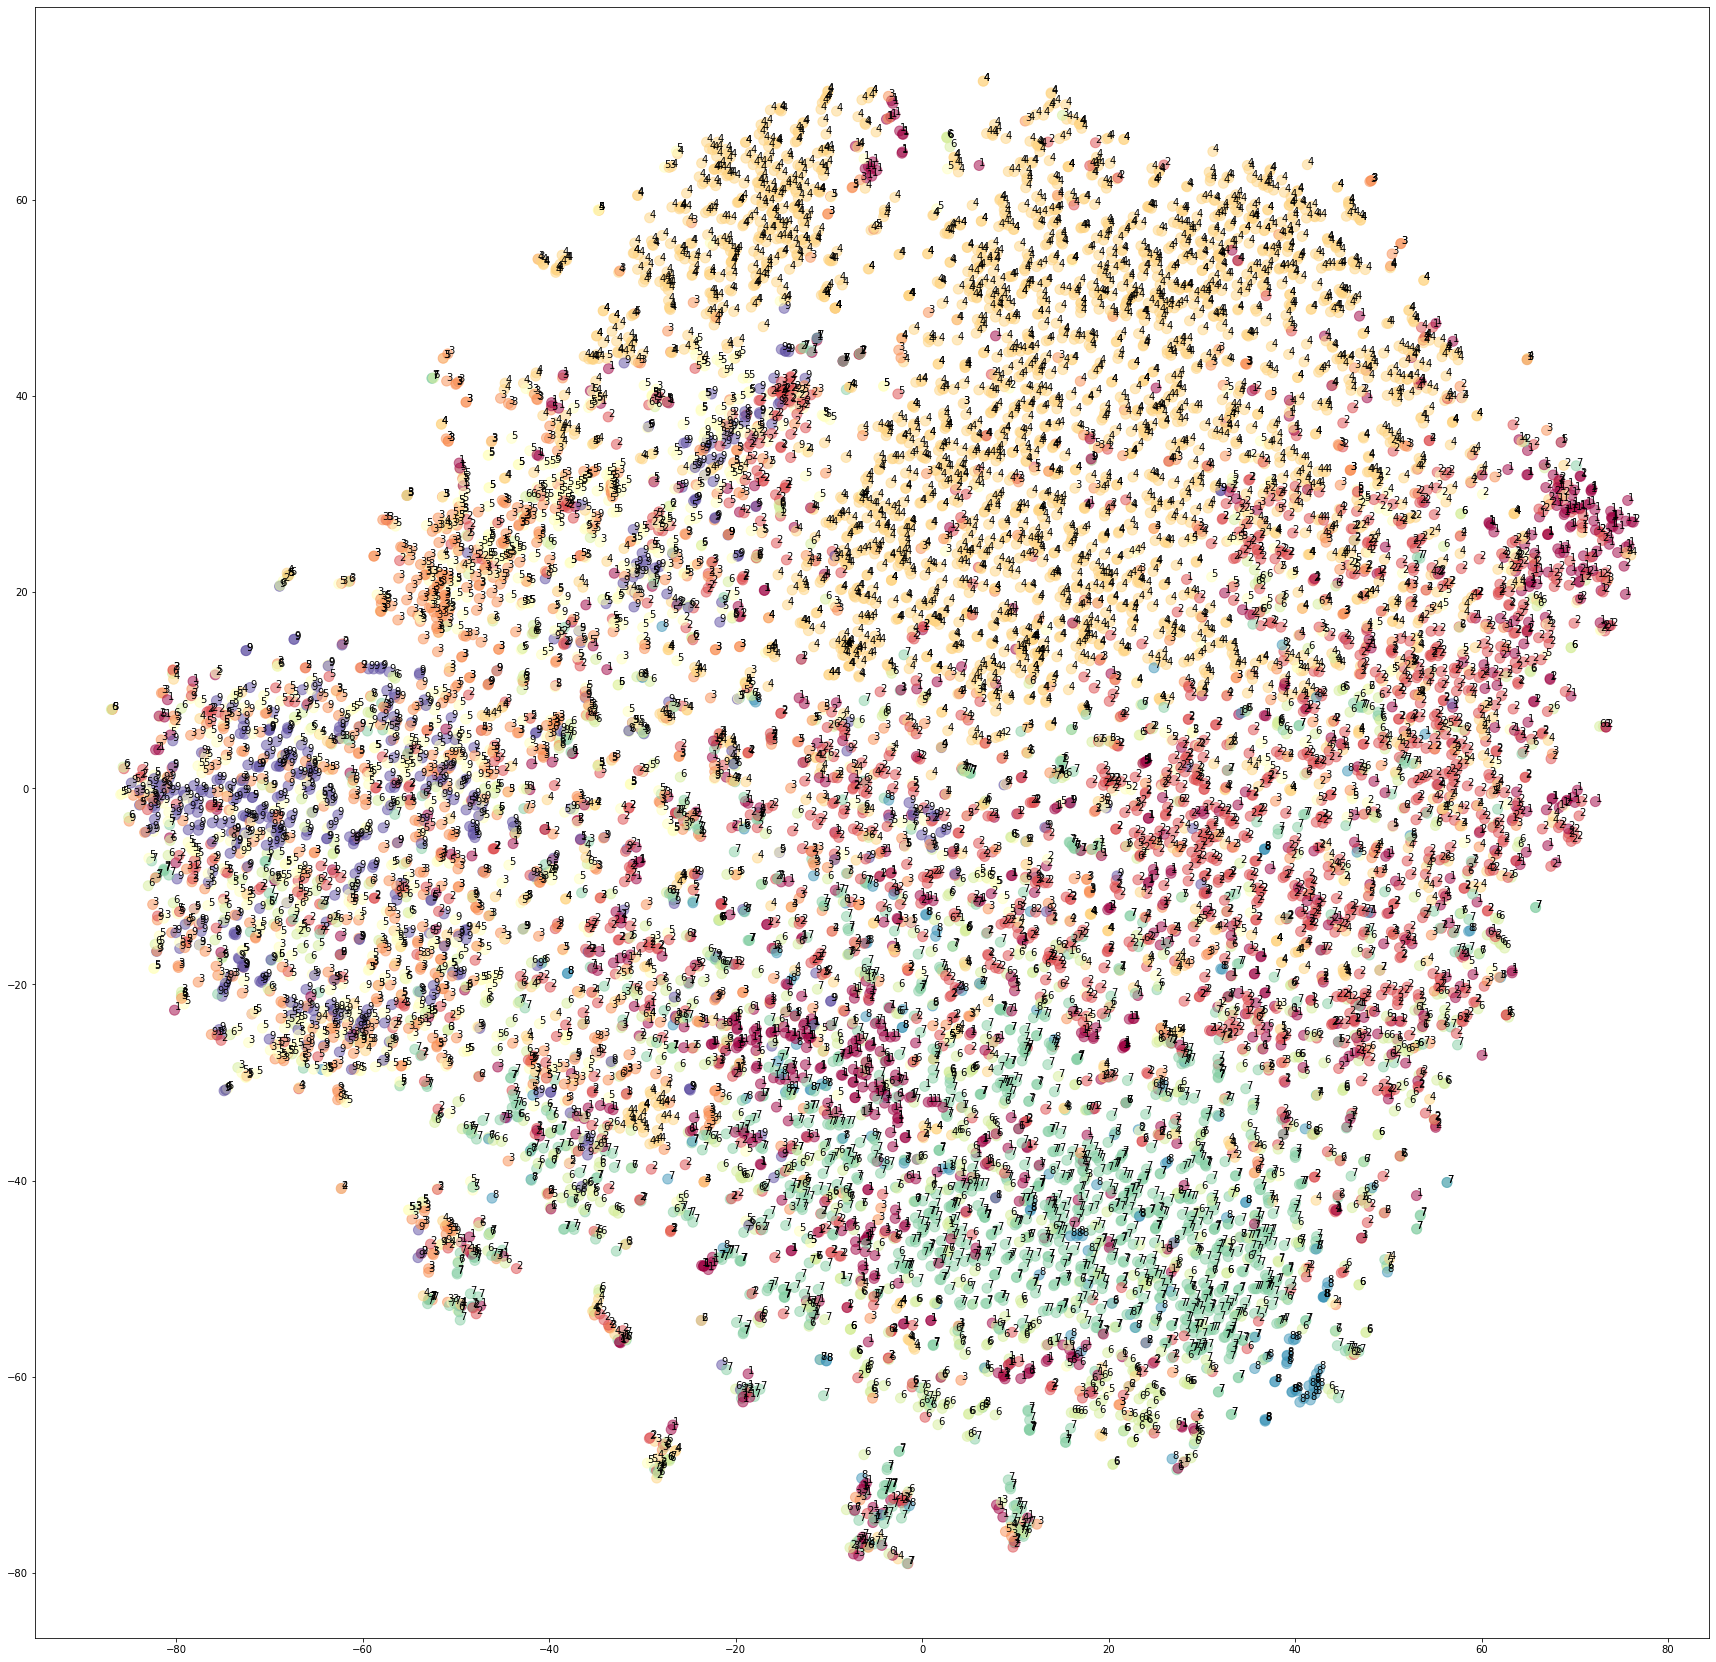

In [64]:
model1 = TSNE(n_components=2, random_state=0)
size = 10000
fig, ax = plt.subplots(figsize = [30,30])

list(y)
Y_tsne = model1.fit_transform(X_train[:size])

plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1],c = y_train[:size], cmap="Spectral", s=100,alpha=.5); 
for j in range(size):    
    plt.annotate(y_pred[j], xy=(Y_tsne[j][0], Y_tsne[j][1]), xytext=(0,0), textcoords='offset points')

plt.savefig("tsne_10000.png")

pandas.core.series.Series

In [ ]:
fig, ax = subplot(figsize= (14,14))

plt.scatter(x_tsne, y_tsne, c)